In [ ]:
!pip install kaggle

In [ ]:
mkdir ~/.kaggle

In [ ]:
cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download zalando-research/fashionmnist

 89% 61.0M/68.8M [00:00<00:00, 77.8MB/s]
100% 68.8M/68.8M [00:00<00:00, 117MB/s] 


In [ ]:
ls

Data/  fashionmnist.zip  NeuralNetwork.ipynb


In [ ]:
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [ ]:
ls

fashion-mnist_test.csv   NeuralNetwork.ipynb     train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-images-idx3-ubyte  train-labels-idx1-ubyte
fashionmnist.zip         t10k-labels-idx1-ubyte


In [ ]:
mkdir Data

In [ ]:
mv *ubyte ./Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/MyDrive/dlAssignments/Assignment1/NeuralNetwork/

/content/drive/MyDrive/dlAssignments/Assignment1/NeuralNetwork


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [146]:
class MyNeuralNetwork:
    # Custom implementation of Neural Network Class
    def __init__(self, N_inputs, N_outputs, N_layers=2, Layer_sizes=[10, 5], activation="sigmoid", learning_rate=0.1, weight_init="random", batch_size=1, num_epochs=200, backpropogation='gd', beta=0.9, gamma=0.999):
        """
        N_inputs: input size
        N_outputs: outputs size
        N_layers: number of hidden layers
        Layer_sizes: list of hidden layer sizes
        activation: activation function to be used (ReLu, Leaky ReLu, sigmoid, linear, tanh, softmax)
        learning_rate: learning rate
        weight_init: weight initialization (zero, random, normal)
        batch_size: batch size
        num_epochs: number of epochs
        """
        self.N_inputs = N_inputs
        self.N_outputs = N_outputs
        self.N_layers = N_layers
        self.Layer_sizes = Layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.backpropogation = backpropogation
        self.beta = beta
        self.gamma = gamma
        self.iterations = 1
        np.random.seed(0)

        model = {}
        if weight_init == "zero":
            model['W1'] = np.zeros((N_inputs, Layer_sizes[0]))
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' +
                      str(i+1)] = np.zeros((Layer_sizes[i-1], Layer_sizes[i]))
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)
                  ] = np.zeros((Layer_sizes[-1], N_outputs))
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        elif weight_init == "random":
            model['W1'] = np.random.randn(N_inputs, Layer_sizes[0])*0.01
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.random.randn(Layer_sizes[i-1],
                                                        Layer_sizes[i])*0.01
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)
                  ] = np.random.randn(Layer_sizes[-1], N_outputs)*0.01
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        elif weight_init == "normal":
            model['W1'] = np.random.normal(
                0, 1, (N_inputs, Layer_sizes[0]))*0.01
            model['b1'] = np.zeros((1, Layer_sizes[0]))
            for i in range(1, N_layers):
                model['W' + str(i+1)] = np.random.normal(0, 1,
                                                         (Layer_sizes[i-1], Layer_sizes[i]))*0.01
                model['b' + str(i+1)] = np.zeros((1, Layer_sizes[i]))
            model['W' + str(N_layers+1)] = np.random.normal(0,
                                                            1, (Layer_sizes[-1], N_outputs))*0.01
            model['b' + str(N_layers+1)] = np.zeros((1, N_outputs))
        else:
            print("Invalid weight initialization")
            return

        self.model = model
        self.activationOutputs = None

    def relu_forward(self, X):
        """
        ReLu activation function for forward propagation
        X: input
        return: output after applying the relu function
        """
        return np.maximum(X, 0)

    def relu_backward(self, X):
        """
        ReLu activation function for backpropagation
        X: input
        return: output after applying the gradient of relu function
        """
        return np.where(X > 0, 1, 0)

    def leaky_relu_forward(self, X):
        """
        Leaky ReLu activation function
        X: input
        return: output after applying the Leaky ReLu function
        """
        return np.maximum(X, 0.01*X)

    def leaky_relu_backward(self, X):
        """
        Leaky ReLu activation function
        X: input
        return: output after applying the gradient of Leaky ReLu function
        """
        return np.where(X > 0, 1, 0.01)

    def sigmoid_forward(self, X):
        """
        Sigmoid activation function
        X: input
        return: output after applying the sigmoid function
        """
        return 1/(1+np.exp(-X))

    def sigmoid_backward(self, X):
        """
        Sigmoid activation function
        X: input
        return: output after applying the gradient of sigmoid function
        """
        return self.sigmoid_forward(X)*(1-self.sigmoid_forward(X))
        # return X*(1-X)

    def linear_forward(self, X):
        """
        Linear activation function
        X: input
        return: output after applying the linear function
        """
        return X

    def linear_backward(self, X):
        """
        Linear activation function
        X: input
        return: output after applying the gradient of linear function
        """
        return np.ones(X.shape)

    def tanh_forward(self, X):
        """
        Tanh activation function
        X: input
        return: output after applying the tanh function
        """
        return (np.exp(X)-np.exp(-X))/(np.exp(X)+np.exp(-X))
        # return np.tanh(X)

    def tanh_backward(self, X):
        """
        Tanh activation function
        X: input
        return: output after applying the gradient of tanh function
        """
        return 1-(self.tanh_forward(X)**2)
        # return 1-X**2

    def softmax_forward(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the softmax function
        """
        exp = np.exp(X - np.max(X))
        return exp/np.sum(exp, axis=1, keepdims=True)

    def softmax_backward_actual(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the gradient of softmax function
        """
        s = self.softmax_forward(X).reshape(-1, 1)
        return np.diagflat(s) - np.dot(s, s.T)

    def softmax_backward(self, X):
        """
        Softmax activation function
        X: input
        return: output after applying the gradient of softmax function
        """
        return self.softmax_forward(X)*(1-self.softmax_forward(X))

    def forward(self, X):
        """
        Forward propagation
        X: input
        return: output after applying the activation function
        """
        if self.activation == "relu":
            currentActivationFuntion = self.relu_forward
        elif self.activation == "leaky_relu":
            currentActivationFuntion = self.leaky_relu_forward
        elif self.activation == "sigmoid":
            currentActivationFuntion = self.sigmoid_forward
        elif self.activation == "linear":
            currentActivationFuntion = self.linear_forward
        elif self.activation == "tanh":
            currentActivationFuntion = self.tanh_forward
        elif self.activation == "softmax":
            currentActivationFuntion = self.softmax_forward
        else:
            raise ValueError("Invalid activation function")

        self.activationOutputs = {}

        self.activationOutputs['Z1'] = np.dot(
            X, self.model['W1']) + self.model['b1']
        self.activationOutputs['A1'] = currentActivationFuntion(
            self.activationOutputs['Z1'])
        # self.activationOutputs['A1'] = np.tanh(self.activationOutputs['Z1'])

        for i in range(2, self.N_layers+1):
            self.activationOutputs['Z' + str(i)] = np.dot(self.activationOutputs['A' + str(
                i-1)], self.model['W' + str(i)]) + self.model['b' + str(i)]
            self.activationOutputs['A' + str(i)] = currentActivationFuntion(
                self.activationOutputs['Z' + str(i)])

        self.activationOutputs['Z' + str(self.N_layers+1)] = np.dot(self.activationOutputs['A' + str(
            self.N_layers)], self.model['W' + str(self.N_layers+1)]) + self.model['b' + str(self.N_layers+1)]
        self.activationOutputs['A' + str(self.N_layers+1)] = self.softmax_forward(
            self.activationOutputs['Z' + str(self.N_layers+1)])

        return self.activationOutputs['A' + str(self.N_layers+1)]

    def backward(self, X, Y):
        """
        Backward propagation
        X: input
        Y: output
        """
        if self.activation == "relu":
            currentActivationFuntion = self.relu_backward
        elif self.activation == "leaky_relu":
            currentActivationFuntion = self.leaky_relu_backward
        elif self.activation == "sigmoid":
            currentActivationFuntion = self.sigmoid_backward
        elif self.activation == "linear":
            currentActivationFuntion = self.linear_backward
        elif self.activation == "tanh":
            currentActivationFuntion = self.tanh_backward
        elif self.activation == "softmax":
            currentActivationFuntion = self.softmax_backward
        else:
            raise ValueError("Invalid activation function")

        # computing the gradients
        self.gradients = {}
        self.gradients['delta' + str(self.N_layers+1)] = (
            self.activationOutputs['A' + str(self.N_layers+1)] - Y)
        self.gradients['dW' + str(self.N_layers+1)] = (1/len(X)) * np.dot(self.activationOutputs['A' + str(
            self.N_layers)].T, self.gradients['delta' + str(self.N_layers+1)])
        self.gradients['db' + str(self.N_layers+1)] = (1/len(X)) * np.sum(
            self.gradients['delta' + str(self.N_layers+1)], axis=0, keepdims=True)

        for i in range(self.N_layers, 1, -1):
            self.gradients['delta' + str(i)] = np.dot(self.gradients['delta' + str(i+1)], self.model['W' + str(
                i+1)].T) * currentActivationFuntion(self.activationOutputs['Z' + str(i)])
            self.gradients['dW' + str(i)] = (1/len(X)) * np.dot(
                self.activationOutputs['A' + str(i-1)].T, self.gradients['delta' + str(i)])
            self.gradients['db' + str(i)] = (1/len(X)) * np.sum(
                self.gradients['delta' + str(i)], axis=0, keepdims=True)

        self.gradients['delta1'] = np.dot(
            self.gradients['delta2'], self.model['W2'].T) * currentActivationFuntion(self.activationOutputs['Z1'])
        self.gradients['dW1'] = (1/len(X)) * \
            np.dot(X.T, self.gradients['delta1'])
        self.gradients['db1'] = (
            1/len(X)) * np.sum(self.gradients['delta1'], axis=0, keepdims=True)

        # updating the model parameters
        if self.backpropogation == 'gd':
            for i in range(1, self.N_layers+2):
                self.model['W' + str(i)] -= self.learning_rate * \
                    self.gradients['dW' + str(i)]
                self.model['b' + str(i)] -= self.learning_rate * \
                    self.gradients['db' + str(i)]

        elif self.backpropogation == 'momentum':
            for i in range(1, self.N_layers+2):
                if ('v_W' + str(i)) not in self.model:
                    self.model['v_W' + str(i)] = 0
                if ('v_b' + str(i)) not in self.model:
                    self.model['v_b' + str(i)] = 0
                self.model['v_W' + str(i)] = (self.beta*self.model['v_W' + str(i)]) - (self.learning_rate * self.gradients['dW' + str(i)])
                self.model['v_b' + str(i)] = (self.beta*self.model['v_b' + str(i)]) - (self.learning_rate * self.gradients['db' + str(i)])
                self.model['W' + str(i)] = self.model['W' + str(i)] + self.model['v_W' + str(i)]
                self.model['b' + str(i)] = self.model['b' + str(i)] + self.model['v_b' + str(i)]

        elif self.backpropogation == 'nag':
            for i in range(1, self.N_layers+2):
                if ('v_W' + str(i)) not in self.model:
                    self.model['v_W' + str(i)] = 0
                if ('v_b' + str(i)) not in self.model:
                    self.model['v_b' + str(i)] = 0
                prevV_W = self.model['v_W' + str(i)]
                prevV_b = self.model['v_b' + str(i)]
                self.model['v_W' + str(i)] = (self.beta*self.model['v_W' + str(i)]) - (self.learning_rate * self.gradients['dW' + str(i)])
                self.model['v_b' + str(i)] = (self.beta*self.model['v_b' + str(i)]) - (self.learning_rate * self.gradients['db' + str(i)])
                self.model['W' + str(i)] = self.model['W' + str(i)] + ((1 + self.beta)*self.model['v_W' + str(i)] - self.beta*prevV_W)
                self.model['b' + str(i)] = self.model['b' + str(i)] + ((1 + self.beta)*self.model['v_b' + str(i)] - self.beta*prevV_b)
        
        elif self.backpropogation == 'adagrad':
            epsilon = 0.0001
            for i in range(1, self.N_layers+2):
                if ('W_squaredSum' + str(i)) not in self.model:
                    self.model['W_squaredSum' + str(i)] = [0]
                if ('b_squaredSum' + str(i)) not in self.model:
                    self.model['b_squaredSum' + str(i)] = [0]
                self.model['W_squaredSum' + str(i)].append(self.model['W_squaredSum' + str(i)][-1] + np.square(self.gradients['dW' + str(i)]))
                self.model['b_squaredSum' + str(i)].append(self.model['b_squaredSum' + str(i)][-1] + np.square(self.gradients['db' + str(i)]))
                self.model['W' + str(i)] = self.model['W' + str(i)] - (self.learning_rate*self.gradients['dW' + str(i)])/np.sqrt(self.model['W_squaredSum' + str(i)][-1] + epsilon)
                self.model['b' + str(i)] = self.model['b' + str(i)] - (self.learning_rate*self.gradients['db' + str(i)])/np.sqrt(self.model['b_squaredSum' + str(i)][-1] + epsilon)

        elif self.backpropogation == 'rmsprop':
            epsilon = 0.1
            for i in range(1, self.N_layers+2):
                if ('v_W' + str(i)) not in self.model:
                    self.model['v_W' + str(i)] = 0
                if ('v_b' + str(i)) not in self.model:
                    self.model['v_b' + str(i)] = 0
                self.model['v_W' + str(i)] = self.beta*self.model['v_W' + str(i)] + (1-self.beta)*np.square(self.gradients['dW' + str(i)])
                self.model['v_b' + str(i)] = self.beta*self.model['v_b' + str(i)] + (1-self.beta)*np.square(self.gradients['db' + str(i)])
                self.model['W' + str(i)] = self.model['W' + str(i)] - (self.learning_rate*self.gradients['dW' + str(i)])/np.sqrt(self.model['v_W' + str(i)] + epsilon)
                self.model['b' + str(i)] = self.model['b' + str(i)] - (self.learning_rate*self.gradients['db' + str(i)])/np.sqrt(self.model['v_b' + str(i)] + epsilon)

        elif self.backpropogation == 'adam':
            epsilon = 0.001
            for i in range(1, self.N_layers+2):
                if ('v_W' + str(i)) not in self.model:
                    self.model['v_W' + str(i)] = 0
                if ('v_b' + str(i)) not in self.model:
                    self.model['v_b' + str(i)] = 0
                if ('s_W' + str(i)) not in self.model:
                    self.model['s_W' + str(i)] = 0
                if ('s_b' + str(i)) not in self.model:
                    self.model['s_b' + str(i)] = 0
                self.model['v_W' + str(i)] = self.beta*self.model['v_W' + str(i)] - (1-self.beta)*self.gradients['dW' + str(i)]
                self.model['v_b' + str(i)] = self.beta*self.model['v_b' + str(i)] - (1-self.beta)*self.gradients['db' + str(i)]
                self.model['s_W' + str(i)] = self.gamma*self.model['s_W' + str(i)] + (1 - self.gamma)*np.square(self.gradients['dW' + str(i)])
                self.model['s_b' + str(i)] = self.gamma*self.model['s_b' + str(i)] + (1 - self.gamma)*np.square(self.gradients['db' + str(i)])
                v_W = self.model['v_W' + str(i)]/(1-np.power(self.beta, self.iterations))
                v_b = self.model['v_b' + str(i)]/(1-np.power(self.beta, self.iterations))
                s_W = self.model['s_W' + str(i)]/(1-np.power(self.gamma, self.iterations)) 
                s_b = self.model['s_b' + str(i)]/(1-np.power(self.gamma, self.iterations))
                # v_W = self.model['v_W' + str(i)]
                # v_b = self.model['v_b' + str(i)]
                # s_W = self.model['s_W' + str(i)]
                # s_b = self.model['s_b' + str(i)]
                # print(np.sqrt(s_W), np.sqrt(s_b))
                self.model['W' + str(i)] = self.model['W' + str(i)] + (self.learning_rate*v_W)/(np.sqrt(s_W) + epsilon)
                self.model['b' + str(i)] = self.model['b' + str(i)] + (self.learning_rate*v_b)/(np.sqrt(s_b) + epsilon)

        else:
            raise ValueError("Invalid backpropogation algorithm")

    def oneHotEncoder(self, y, n_classes):
        """
        One hot encoder
        y: input
        return: encoded output
        """
        m = y.shape[0]
        y_oht = np.zeros((m, n_classes))
        y_oht[np.arange(m), y] = 1
        return y_oht

    def crossEntropyLoss(self, y_oht, y_prob):
        """
        Cross entropy loss
        y_oht: one hot encoded output
        y_prob: probabilities for classes
        return: cross entropy loss
        """
        return -np.mean(y_oht * np.log(y_prob + 1e-8))

    def fit(self, X, y, validX=None, validY=None, logs=True):
        """
        Fit the model to the data
        X: input
        Y: output
        epochs: number of epochs
        """
        train_losses = []
        valid_losses = []
        train_accs = []
        valid_accs = []
        classes = self.N_outputs
        batchSize = self.batch_size
        y_oht = self.oneHotEncoder(y, classes)
        if validX is not None and validY is not None:
            y_oht_valid = self.oneHotEncoder(validY, classes)
        for i in range(self.num_epochs):
            for j in range(0, X.shape[0], batchSize):
                X_batch = X[j:j+batchSize]
                y_batch = y_oht[j:j+batchSize]
                y_ = self.forward(X_batch)
                self.backward(X_batch, y_batch)
            y_ = self.forward(X)
            train_loss = self.crossEntropyLoss(y_oht, y_)
            train_losses.append(train_loss)
            if validX is not None and validY is not None:
                y_valid = self.forward(validX)
                valid_loss = self.crossEntropyLoss(y_oht_valid, y_valid)
                valid_losses.append(valid_loss)
                validAcc = self.score(validX, validY)
                valid_accs.append(validAcc)
            trainAcc = self.score(X, y)
            train_accs.append(trainAcc)
            if logs:
                print("Epoch: {}, Loss: {}, Score: {}".format(
                    i, train_loss, trainAcc))
            self.iterations += 1
        if validX is not None and validY is not None:
            return train_losses, valid_losses, train_accs, valid_accs
        return train_losses, train_accs

    def predict_proba(self, X):
        """
        Predict probabilities
        X: input
        return: probabilities
        """
        return self.forward(X)

    def predict(self, X):
        """
        Predict classes
        X: input
        return: classes
        """
        return np.argmax(self.forward(X), axis=1)

    def score(self, X, y):
        """
        Score the model
        X: input
        Y: output
        return: accuracy
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)*100

    def saveWeights(self, filename):
        """
        Save the weights
        filename: name of the file
        """
        np.save(filename, self.model, allow_pickle=True)

    def loadWeights(self, filename):
        """
        Load the weights
        filename: name of the file
        """
        self.model = np.load(filename, allow_pickle=True).item()

In [115]:
ls Data

fashion-mnist_test.csv   t10k-images-idx3-ubyte  train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


In [116]:
trainData = pd.read_csv('./Data/fashion-mnist_train.csv')
testData = pd.read_csv('./Data/fashion-mnist_test.csv')

In [117]:
trainData.shape, testData.shape

((60000, 785), (10000, 785))

In [118]:
trainData = trainData.values
testData = testData.values

In [119]:
trainX = trainData[:, 1:]
trainY = trainData[:, 0]
testX = testData[:, 1:]
testY = testData[:, 0]

In [120]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [121]:
#To visualize this, I have to convert it to a 2D array of size 28 x 28
def drawImg(X, Y, i):
    plt.imshow(X[i].reshape(28, 28), cmap='gray')
    plt.title("Label " + str(Y[i]))
    plt.show()

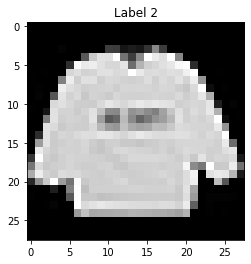

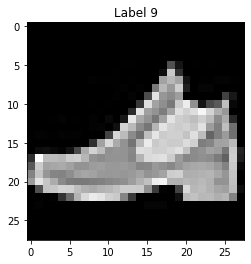

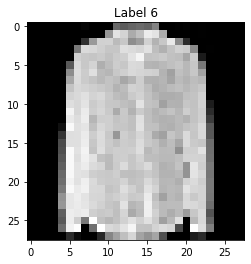

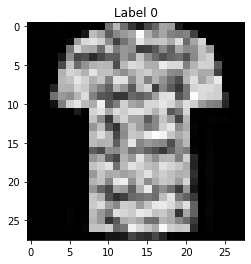

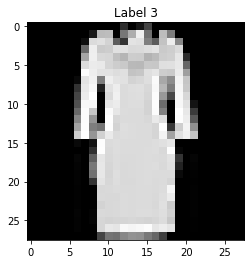

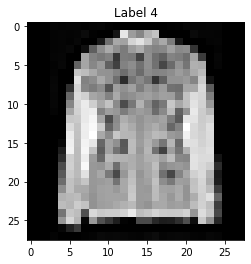

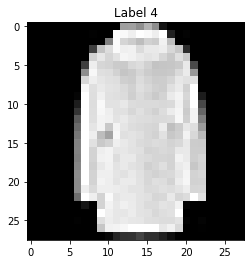

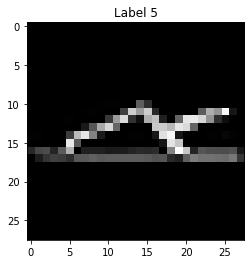

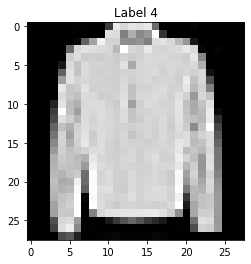

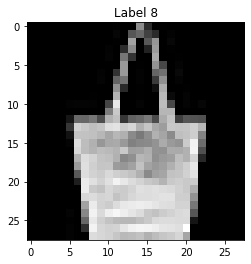

In [122]:
for i in range(10):
    drawImg(trainX, trainY, i)

In [123]:
normalize = StandardScaler()
trainX = normalize.fit_transform(trainX)
testX = normalize.transform(testX)

In [147]:
# adam
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[
                        256], activation="relu", learning_rate=0.001, weight_init="random", num_epochs=50, batch_size=len(trainX), backpropogation='adam')

In [148]:
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)

Epoch: 0, Loss: 0.22186197683874342, Score: 55.59166666666666
Epoch: 1, Loss: 0.2131715093190313, Score: 61.31333333333333
Epoch: 2, Loss: 0.20381768037386774, Score: 63.38333333333333
Epoch: 3, Loss: 0.19353731935355542, Score: 64.03166666666667
Epoch: 4, Loss: 0.1824570949531362, Score: 64.39666666666668
Epoch: 5, Loss: 0.170915750714597, Score: 64.70666666666666
Epoch: 6, Loss: 0.15937920759417978, Score: 64.96333333333332
Epoch: 7, Loss: 0.14834711223262337, Score: 65.245
Epoch: 8, Loss: 0.13824055165237165, Score: 65.54333333333334
Epoch: 9, Loss: 0.12931177167797855, Score: 65.745
Epoch: 10, Loss: 0.12162791543170051, Score: 65.95
Epoch: 11, Loss: 0.11511874987880491, Score: 66.13166666666666
Epoch: 12, Loss: 0.10963500326186035, Score: 66.19666666666667
Epoch: 13, Loss: 0.1049858029809867, Score: 66.43666666666667
Epoch: 14, Loss: 0.10096906677577928, Score: 66.68666666666667
Epoch: 15, Loss: 0.09740422528737626, Score: 67.11333333333333
Epoch: 16, Loss: 0.09416144365605707, Sco

In [149]:
print("Test Accuracy ReLU: {}".format(model.score(testX, testY)))

Test Accuracy ReLU: 80.34


In [62]:
# rmsprop
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[
                        256], activation="relu", learning_rate=0.08, weight_init="random", num_epochs=50, batch_size=len(trainX), backpropogation='rmsprop')

In [63]:
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)

Epoch: 0, Loss: 0.22135004162616867, Score: 56.96666666666667
Epoch: 1, Loss: 0.21002696153858322, Score: 63.834999999999994
Epoch: 2, Loss: 0.1926974130531193, Score: 63.690000000000005
Epoch: 3, Loss: 0.1689937687278571, Score: 61.586666666666666
Epoch: 4, Loss: 0.14522015277207373, Score: 59.973333333333336
Epoch: 5, Loss: 0.12725919447384532, Score: 61.526666666666664
Epoch: 6, Loss: 0.11490772900660474, Score: 64.66333333333333
Epoch: 7, Loss: 0.10596422131315256, Score: 67.30833333333334
Epoch: 8, Loss: 0.09905553510928601, Score: 68.93
Epoch: 9, Loss: 0.09342695165674651, Score: 70.19333333333333
Epoch: 10, Loss: 0.08870511647714999, Score: 71.17833333333333
Epoch: 11, Loss: 0.08470173175886034, Score: 72.00166666666667
Epoch: 12, Loss: 0.08129016976065913, Score: 72.72166666666666
Epoch: 13, Loss: 0.07836662873574185, Score: 73.28833333333333
Epoch: 14, Loss: 0.0758492873887636, Score: 73.80499999999999
Epoch: 15, Loss: 0.07367892394799315, Score: 74.30333333333333
Epoch: 16, L

In [64]:
print("Test Accuracy ReLU: {}".format(model.score(testX, testY)))

Test Accuracy ReLU: 80.84


In [42]:
# adagrad
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[
                        256], activation="relu", learning_rate=0.08, weight_init="random", num_epochs=50, batch_size=len(trainX), backpropogation='adagrad')

In [43]:
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)

Epoch: 0, Loss: 0.3233817708063344, Score: 20.163333333333334
Epoch: 1, Loss: 0.7896464877076989, Score: 34.968333333333334
Epoch: 2, Loss: 1.0817646891776578, Score: 31.255
Epoch: 3, Loss: 1.4240663491653913, Score: 16.32166666666667
Epoch: 4, Loss: 1.475182970258472, Score: 14.965
Epoch: 5, Loss: 1.0940245578175962, Score: 31.458333333333332
Epoch: 6, Loss: 0.7152495488547025, Score: 51.35333333333333
Epoch: 7, Loss: 0.6963603296776386, Score: 50.36000000000001
Epoch: 8, Loss: 0.45676978718424893, Score: 62.75833333333334
Epoch: 9, Loss: 0.3426606056686606, Score: 69.78
Epoch: 10, Loss: 0.31392800687718986, Score: 69.77333333333333
Epoch: 11, Loss: 0.34157182287318777, Score: 65.13166666666666
Epoch: 12, Loss: 0.37674486411183583, Score: 68.07666666666667
Epoch: 13, Loss: 0.24731157822996624, Score: 71.47666666666666
Epoch: 14, Loss: 0.17976212981508255, Score: 75.23666666666666
Epoch: 15, Loss: 0.16207891767546972, Score: 76.12
Epoch: 16, Loss: 0.12335893571084744, Score: 78.2783333

In [44]:
print("Test Accuracy ReLU: {}".format(model.score(testX, testY)))

Test Accuracy ReLU: 83.73


In [33]:
# Gradient descent with momentum nag
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[
                        256], activation="relu", learning_rate=0.08, weight_init="random", num_epochs=50, batch_size=len(trainX), backpropogation='nag')

In [34]:
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)

Epoch: 0, Loss: 0.2250467901654805, Score: 50.13333333333333
Epoch: 1, Loss: 0.21654758925160675, Score: 61.62
Epoch: 2, Loss: 0.20330870790745942, Score: 64.31166666666667
Epoch: 3, Loss: 0.18227289311019967, Score: 63.629999999999995
Epoch: 4, Loss: 0.15439882892556098, Score: 61.77166666666667
Epoch: 5, Loss: 0.1286659850213582, Score: 60.51166666666666
Epoch: 6, Loss: 0.11108253782488098, Score: 62.295
Epoch: 7, Loss: 0.09974342332870256, Score: 65.92
Epoch: 8, Loss: 0.09167361645381832, Score: 68.58333333333333
Epoch: 9, Loss: 0.0855150565293716, Score: 70.07166666666666
Epoch: 10, Loss: 0.08037334919545416, Score: 71.455
Epoch: 11, Loss: 0.07621944138629341, Score: 72.93333333333332
Epoch: 12, Loss: 0.07306960584605525, Score: 73.85000000000001
Epoch: 13, Loss: 0.07057244652116834, Score: 74.47500000000001
Epoch: 14, Loss: 0.06841857304075774, Score: 74.95333333333333
Epoch: 15, Loss: 0.0664392534918507, Score: 75.48666666666666
Epoch: 16, Loss: 0.06453720144618014, Score: 76.036

In [35]:
print("Test Accuracy ReLU: {}".format(model.score(testX, testY)))

Test Accuracy ReLU: 85.50999999999999


In [26]:
# Gradient descent with momentum
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[
                        256], activation="relu", learning_rate=0.08, weight_init="random", num_epochs=50, batch_size=len(trainX), backpropogation='momentum')

In [27]:
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)

Epoch: 0, Loss: 0.22776693274523557, Score: 36.59833333333333
Epoch: 1, Loss: 0.22198351716395195, Score: 55.87833333333333
Epoch: 2, Loss: 0.21332166604181943, Score: 63.339999999999996
Epoch: 3, Loss: 0.20031285043367145, Score: 64.45666666666666
Epoch: 4, Loss: 0.1808595117459976, Score: 63.89666666666667
Epoch: 5, Loss: 0.15566922056623983, Score: 62.48166666666667
Epoch: 6, Loss: 0.13136878386151143, Score: 60.748333333333335
Epoch: 7, Loss: 0.11418367808794426, Score: 60.97
Epoch: 8, Loss: 0.10371815666485858, Score: 63.260000000000005
Epoch: 9, Loss: 0.09669870846914823, Score: 66.51
Epoch: 10, Loss: 0.09089280592130045, Score: 68.93333333333334
Epoch: 11, Loss: 0.08660473998436928, Score: 69.72833333333334
Epoch: 12, Loss: 0.08219454626102814, Score: 71.055
Epoch: 13, Loss: 0.07835460815029145, Score: 72.99166666666666
Epoch: 14, Loss: 0.07667723540856126, Score: 73.66333333333334
Epoch: 15, Loss: 0.0745646223869906, Score: 73.99
Epoch: 16, Loss: 0.07198262819108892, Score: 74.

In [28]:
print("Test Accuracy ReLU: {}".format(model.score(testX, testY)))

Test Accuracy ReLU: 85.24000000000001


In [29]:
# Gradient descent
model = MyNeuralNetwork(N_inputs=784, N_outputs=10, N_layers=1, Layer_sizes=[
                        256], activation="relu", learning_rate=0.08, weight_init="random", num_epochs=50, batch_size=len(trainX))

In [30]:
trainLoss, testLoss, trainAccs, testAccs = model.fit(
    trainX, trainY, validX=testX, validY=testY, logs=True)

Epoch: 0, Loss: 0.22776693274523557, Score: 36.59833333333333
Epoch: 1, Loss: 0.22468121624147097, Score: 50.81
Epoch: 2, Loss: 0.22140444830067474, Score: 56.12166666666667
Epoch: 3, Loss: 0.21776316901350662, Score: 59.555
Epoch: 4, Loss: 0.21360005771375642, Score: 62.03833333333333
Epoch: 5, Loss: 0.2087748591426473, Score: 63.041666666666664
Epoch: 6, Loss: 0.20318078724810387, Score: 63.19166666666667
Epoch: 7, Loss: 0.1967723543893887, Score: 63.00666666666667
Epoch: 8, Loss: 0.18959914210078485, Score: 62.51833333333333
Epoch: 9, Loss: 0.18182505791730144, Score: 61.82333333333333
Epoch: 10, Loss: 0.1737181933207491, Score: 61.095
Epoch: 11, Loss: 0.16559340002489714, Score: 60.405
Epoch: 12, Loss: 0.15774162785365486, Score: 60.026666666666664
Epoch: 13, Loss: 0.150380727248746, Score: 60.07
Epoch: 14, Loss: 0.14364161197362874, Score: 60.38166666666667
Epoch: 15, Loss: 0.13757342941734413, Score: 60.83333333333333
Epoch: 16, Loss: 0.13215765971615198, Score: 61.45833333333333

In [31]:
print("Test Accuracy ReLU: {}".format(model.score(testX, testY)))

Test Accuracy ReLU: 74.28
